<a href="https://colab.research.google.com/github/aviralsomani/driv-face-classifier/blob/master/AviralSomani_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=959e0b841dfe77bba893a304a0ed0c2659d0db9cf84bda6b43802824f0e674b1
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import random
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

tmp_dir = 'data/tmp'
img_dir = 'data/img'
trn_dir = 'data/trn'
val_dir = 'data/val'
uci_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'

Using TensorFlow backend.


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def load_data():
  if not os.path.exists(img_dir):
    os.makedirs(tmp_dir)
    os.makedirs(img_dir)
    print("Downloading dataset to "+ tmp_dir)
    file = wget.download(uci_url, out=tmp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(tmp_dir)
    pzf = PyZipFile(tmp_dir + '/DrivFace/DrivImages.zip')
    pzf.extractall(tmp_dir)
    print("Moving files to " + img_dir)
    for file in os.listdir(tmp_dir + '/DrivImages'):
      shutil.move(tmp_dir+'/DrivImages/'+file, img_dir+'/'+file)
    shutil.move(tmp_dir + '/DrivFace/drivPoints.txt', img_dir + '/drivPoints.txt')
    shutil.rmtree(tmp_dir)

In [0]:
def move_train_val(train_dir, validation_dir, files, ratio):
  ind = 0
  for fname in files:
    src = os.path.join(img_dir, fname + '.jpg')
    t_dest = os.path.join(train_dir, fname + '')
    ind = ind + 1
    if ind < len(files)*ratio:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(train_dir, fname + '.jpg'))
    else:
      shutil.move(os.path.join(img_dir, fname + '.jpg'),
                  os.path.join(validation_dir, fname + '.jpg'))

In [0]:
import matplotlib.pyplot as plt
def show_plots(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.ylim(0, 1)
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.plot(epochs, acc, 'bo', label='Training Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


In [0]:
def split_data(img_dir, trn_dir, val_dir, ratio):
  if not os.path.exists(trn_dir):
    os.makedirs(trn_dir)
    os.makedirs(val_dir)
    tff_dir = os.path.join(trn_dir, 'ff')
    tll_dir = os.path.join(trn_dir, 'll')
    tlr_dir = os.path.join(trn_dir, 'lr')
    os.makedirs(tff_dir)
    os.makedirs(tll_dir)
    os.makedirs(tlr_dir)
    vff_dir = os.path.join(val_dir, 'ff')
    vll_dir = os.path.join(val_dir, 'll')
    vlr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(vff_dir)
    os.makedirs(vll_dir)
    os.makedirs(vlr_dir)
    df = pd.read_csv(img_dir + '/drivPoints.txt')['fileName']
    ff = [f for f in df if 'f' in f]
    random.shuffle(ff)
    ll = [f for f in df if 'll' in f]
    random.shuffle(ll)
    lr = [f for f in df if 'lr' in f]
    random.shuffle(lr)
    ind = 0
    move_train_val(tff_dir, vff_dir, ff, ratio)
    move_train_val(tll_dir, vll_dir, ll, ratio)
    move_train_val(tlr_dir, vlr_dir, lr, ratio)

In [0]:
def return_data(img_dir, trn_dir, val_dir):
  for out in [trn_dir, val_dir]:
    for lab in ['ff', 'll', 'lr']:
      src = os.path.join(out, lab)
      files = os.listdir(src)
      for f in files:
        shutil.move(os.path.join(src, f), img_dir)
    shutil.rmtree(out)

In [0]:
def split_k_bins(trn_dir, k):
  bins = list(range(0, k))
  for b in bins:
    path = os.path.join(trn_dir, ('b'+str(b)))
    if not os.path.exists(path):
      os.makedirs(path)
      os.makedirs(os.path.join(path, 'ff'))
      os.makedirs(os.path.join(path, 'll'))
      os.makedirs(os.path.join(path, 'lr'))
  for lab in ['ff', 'll', 'lr']:
    src = os.path.join(trn_dir, lab)
    for f in os.listdir(src):
      if len(bins) == 0:
        bins = list(range(0, k))
      bin_num = random.choice(bins)
      bins.remove(bin_num)
      bin_dir = os.path.join(trn_dir, ('b' + str(bin_num)))
      shutil.move(os.path.join(src, f), os.path.join(bin_dir, lab))
    shutil.rmtree(src)

In [0]:
def coalesce_train_val(trn_dir, j):
  target = 'b' + str(j)
  bins = [b for b in os.listdir(trn_dir) if b != target]
  ingroup = os.path.join(trn_dir, 'in')
  os.makedirs(ingroup)
  os.makedirs(os.path.join(ingroup, 'ff'))
  os.makedirs(os.path.join(ingroup, 'll'))
  os.makedirs(os.path.join(ingroup, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      srclab = os.path.join(src, lab)
      for f in os.listdir(srclab):
        shutil.copy(os.path.join(srclab, f), os.path.join(ingroup, lab))
  outgroup = os.path.join(trn_dir, 'out')
  os.makedirs(outgroup)
  os.makedirs(os.path.join(outgroup, 'ff'))
  os.makedirs(os.path.join(outgroup, 'll'))
  os.makedirs(os.path.join(outgroup, 'lr'))
  outbin = os.path.join(trn_dir, target)
  for lab in ['ff', 'll', 'lr']:
    srclab = os.path.join(outbin, lab)
    for f in os.listdir(srclab):
      shutil.copy(os.path.join(srclab, f), os.path.join(outgroup, lab))


In [0]:
def decoalesce_train_val(trn_dir):
  ingroup = os.path.join(trn_dir, 'in')
  outgroup = os.path.join(trn_dir, 'out')
  shutil.rmtree(ingroup)
  shutil.rmtree(outgroup)

In [0]:
def return_bins(trn_dir):
  bins = os.listdir(trn_dir)
  os.makedirs(os.path.join(trn_dir, 'ff'))
  os.makedirs(os.path.join(trn_dir, 'll'))
  os.makedirs(os.path.join(trn_dir, 'lr'))
  for b in bins:
    src = os.path.join(trn_dir, b)
    for lab in ['ff', 'll', 'lr']:
      insrc = os.path.join(src, lab)
      for f in os.listdir(insrc):
        shutil.move(os.path.join(insrc, f), os.path.join(trn_dir, lab))
    shutil.rmtree(src)

In [0]:
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [0]:
def run_k_fold_cross_val(model, k, steps_per_epoch=100, epochs=10, validation_steps=50):
  tr_dgen = ImageDataGenerator(rescale=1./255)
  vl_dgen = ImageDataGenerator(rescale=1./255)
  split_k_bins(trn_dir, k)
  for i in range(0, k):
    print('Bin ', i+1, 'out of', k)
    coalesce_train_val(trn_dir, i)
    tr_gen = tr_dgen.flow_from_directory(os.path.join(trn_dir, 'in'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

    vl_gen = vl_dgen.flow_from_directory(os.path.join(trn_dir, 'out'), target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')
                                         
    hist = model.fit_generator(tr_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                               validation_data=vl_gen, validation_steps=validation_steps)
    show_plots(hist)
    decoalesce_train_val(trn_dir)
  return_bins(trn_dir)


In [0]:
load_data()
split_data(img_dir, trn_dir, val_dir, 0.8)


Unzipping the files..
Moving files to data/img


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        padding='same', 
                        input_shape=(64, 64, 3)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        padding='same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Bin  1 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 18s 180ms/step - loss: 0.4178 - acc: 0.9033 - val_loss: 0.2592 - val_acc: 0.9006
Epoch 2/10
100/100 [==============================] - 12s 123ms/step - loss: 0.2397 - acc: 0.9249 - val_loss: 0.1089 - val_acc: 0.9503
Epoch 3/10
100/100 [==============================] - 12s 123ms/step - loss: 0.1163 - acc: 0.9577 - val_loss: 0.0046 - val_acc: 0.9635
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0490 - acc: 0.9815 - val_loss: 0.0011 - val_acc: 0.9628
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0255 - acc: 0.9885 - val_loss: 0.0313 - val_acc: 0.9669
Epoch 6/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0173 - acc: 0.9937 - val_loss: 0.1316 - val_acc: 0.9515
Epoch 7/10
100/100 [==============================] - 12s 119ms/step - loss: 0.0180 - acc: 0

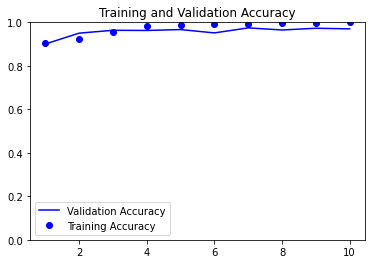

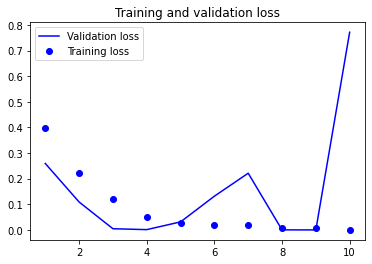

Bin  2 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.1195 - acc: 0.9699 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0393 - acc: 0.9884 - val_loss: 0.0059 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 6.1146e-04 - acc: 1.0000 - val_loss: 0.0104 - val_acc: 0.9944
Epoch 5/10
100/100 [==============================] - 12s 121ms/step - loss: 0.0042 - acc: 0.9984 - val_loss: 0.0268 - val_acc: 0.9878
Epoch 6/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0464 - acc: 0.9901 - val_loss: 0.0297 - val_acc: 0.9944
Epoch 7/10
100/100 [==============================] - 12s 120ms/step - loss: 0.0019 - ac

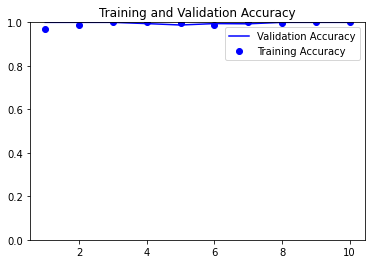

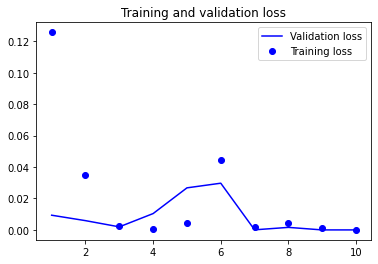

Bin  3 out of 3
Found 322 images belonging to 3 classes.
Found 161 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0121 - acc: 0.9958 - val_loss: 1.3046e-04 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 12s 124ms/step - loss: 2.0569e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 122ms/step - loss: 4.6647e-04 - acc: 1.0000 - val_loss: 5.7504e-05 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0277 - acc: 0.9947 - val_loss: 0.0967 - val_acc: 0.9876
Epoch 5/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0578 - acc: 0.9880 - val_loss: 0.1608 - val_acc: 0.9812
Epoch 6/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 1.4643e-05 - val_acc: 0.9944
Epoch 7/10
100/100 [==============================] - 12s 119ms/step - l

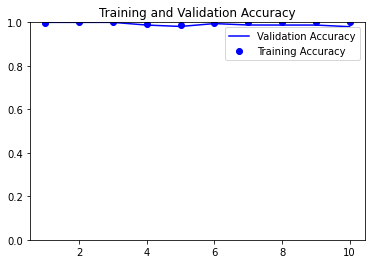

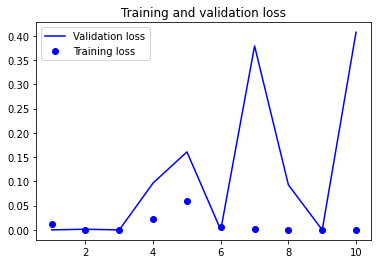

In [0]:
run_k_fold_cross_val(model, k=3, epochs=10)

In [0]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=20, class_mode='categorical')

Found 123 images belonging to 3 classes.


In [0]:
model.evaluate_generator(test_gen)


[5.847661972045898, 0.9756097793579102]

In [0]:
model2 = models.Sequential()
model2.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

Bin  1 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.5594 - acc: 0.8467 - val_loss: 0.2268 - val_acc: 0.9062
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.3816 - acc: 0.9018 - val_loss: 0.3185 - val_acc: 0.9062
Epoch 3/10
100/100 [==============================] - 13s 133ms/step - loss: 0.2924 - acc: 0.9048 - val_loss: 0.4724 - val_acc: 0.9062
Epoch 4/10
100/100 [==============================] - 13s 130ms/step - loss: 0.2153 - acc: 0.9120 - val_loss: 0.2406 - val_acc: 0.9062
Epoch 5/10
100/100 [==============================] - 13s 131ms/step - loss: 0.1801 - acc: 0.9190 - val_loss: 0.0947 - val_acc: 0.9062
Epoch 6/10
100/100 [==============================] - 14s 137ms/step - loss: 0.1354 - acc: 0.9432 - val_loss: 0.0840 - val_acc: 0.9375
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss: 0.1249 - acc: 0

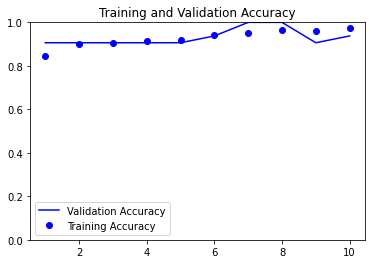

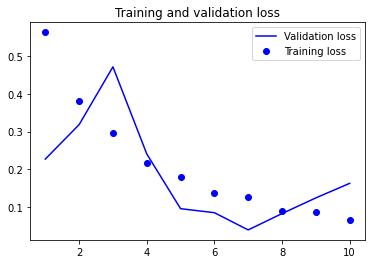

Bin  2 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0912 - acc: 0.9705 - val_loss: 0.0667 - val_acc: 0.9688
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0567 - acc: 0.9795 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 14s 136ms/step - loss: 0.0508 - acc: 0.9827 - val_loss: 0.1133 - val_acc: 0.9688
Epoch 4/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0373 - acc: 0.9918 - val_loss: 1.9471e-06 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0247 - acc: 0.9944 - val_loss: 8.1263e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0202 - acc: 0.9939 - val_loss: 8.8241e-04 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0

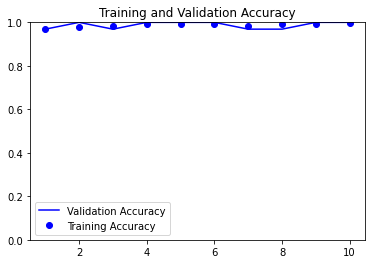

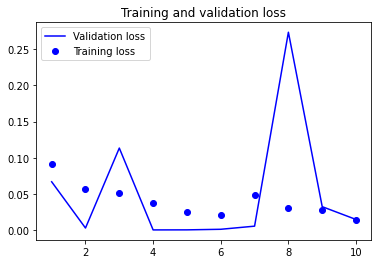

Bin  3 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0221 - acc: 0.9924 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0200 - acc: 0.9944 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0185 - acc: 0.9944 - val_loss: 8.4439e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0256 - acc: 0.9913 - val_loss: 3.2796e-05 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0253 - acc: 0.9908 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 137ms/step - loss: 0.0177 - acc: 0.9954 - val_loss: 0.0256 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0

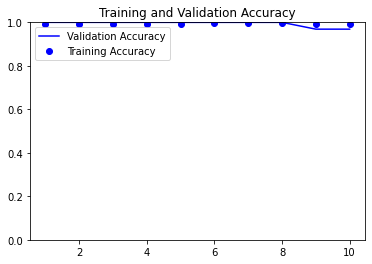

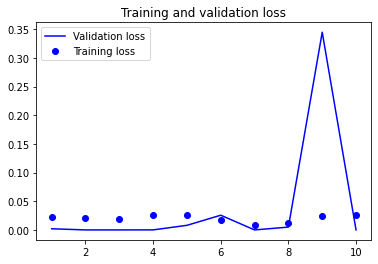

Bin  4 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0090 - acc: 0.9974 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0343 - acc: 0.9964 - val_loss: 2.2925e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0285 - acc: 0.9908 - val_loss: 5.7239e-04 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 132ms/step - loss: 0.0059 - acc: 0.9990 - val_loss: 1.5589e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0139 - acc: 0.9944 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0086 - acc: 0.9969 - val_loss: 8.0453e-04 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 133ms/step - loss:

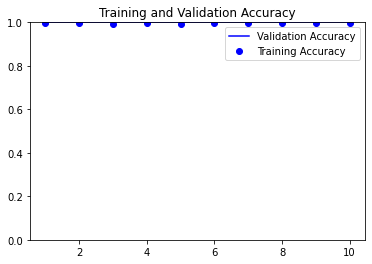

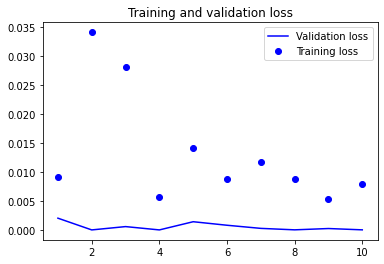

Bin  5 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 144ms/step - loss: 0.0094 - acc: 0.9975 - val_loss: 1.6092e-05 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0092 - acc: 0.9975 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 14s 135ms/step - loss: 0.0302 - acc: 0.9923 - val_loss: 1.4802e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 132ms/step - loss: 0.0130 - acc: 0.9964 - val_loss: 3.8936e-04 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 127ms/step - loss: 0.0142 - acc: 0.9959 - val_loss: 7.3651e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 135ms/step - loss: 0.0141 - acc: 0.9959 - val_loss: 1.8823e-05 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 134ms/step

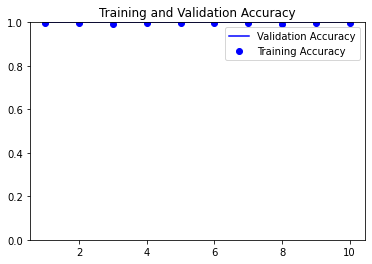

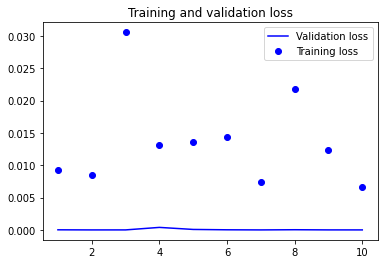

Bin  6 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0121 - acc: 0.9979 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0311 - acc: 0.9934 - val_loss: 9.6444e-04 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0296 - acc: 0.9933 - val_loss: 0.0257 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0242 - acc: 0.9934 - val_loss: 1.3483e-04 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0045 - acc: 0.9985 - val_loss: 4.0000e-04 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 0.0040 - acc: 0.9990 - val_loss: 5.5020e-08 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 129ms/step - l

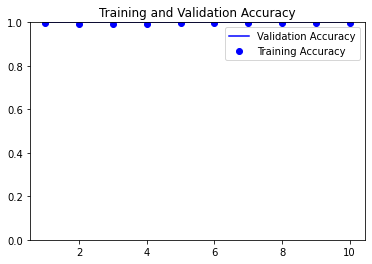

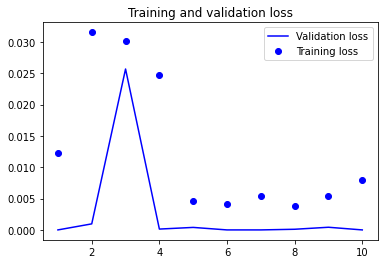

Bin  7 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 8.9668e-04 - acc: 1.0000 - val_loss: 8.1853e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0028 - acc: 0.9985 - val_loss: 9.9341e-09 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 132ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 128ms/step - loss: 0.0023 - acc: 0.9990 - val_loss: 9.9341e-09 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0096 - acc: 0.9975 - val_loss: 2.9133e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 135ms/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 130ms/

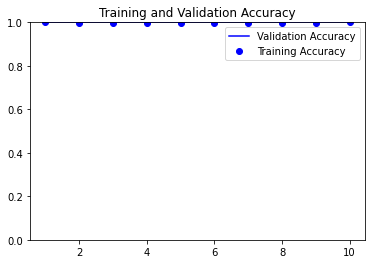

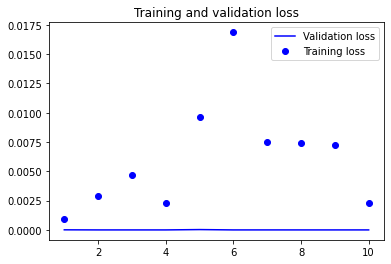

Bin  8 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 138ms/step - loss: 0.0036 - acc: 0.9990 - val_loss: 1.3908e-07 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 128ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0026 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0018 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 126ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 7.9988e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 133ms/

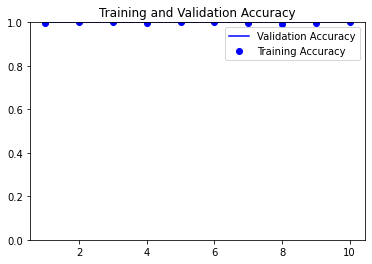

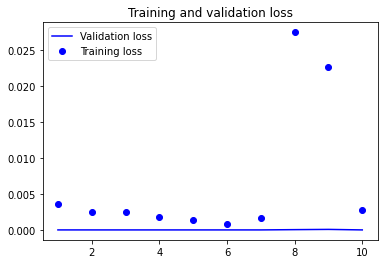

Bin  9 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0058 - acc: 0.9980 - val_loss: 3.2881e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 8.1469e-04 - acc: 1.0000 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0031 - acc: 0.9980 - val_loss: 1.5199e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 3.0796e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 127ms/step - loss: 1.8807e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 0.0034 - acc: 0.9985 - val_loss: 3.9736e-08 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 13

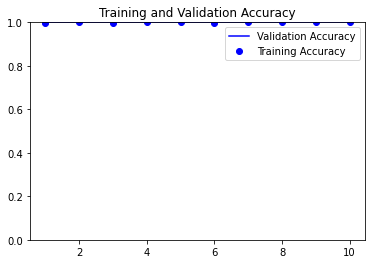

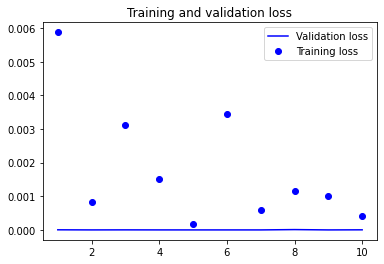

Bin  10 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 9.6589e-04 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0102 - acc: 0.9969 - val_loss: 6.9539e-08 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 14s 136ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 6.9539e-08 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0021 - acc: 0.9990 - val_loss: 5.9256e-05 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0093 - acc: 0.9969 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 14s 136ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 4.5199e-06 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 132ms

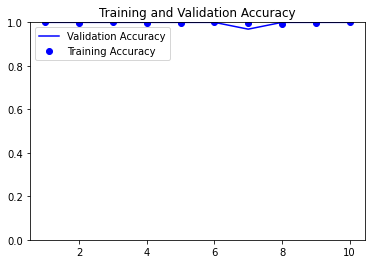

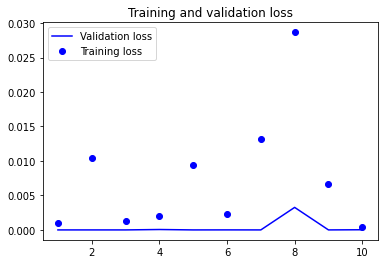

Bin  11 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 0.0013 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0064 - acc: 0.9980 - val_loss: 5.4139e-06 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0039 - acc: 0.9974 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0121 - acc: 0.9969 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 131ms/ste

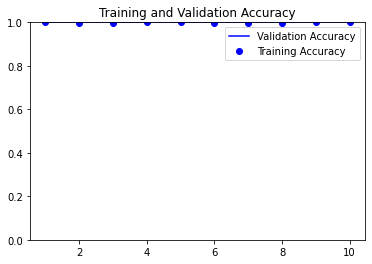

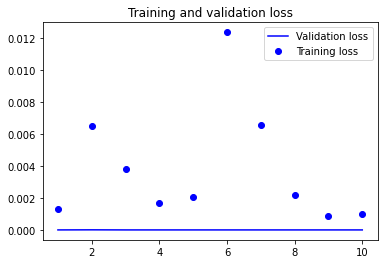

Bin  12 out of 15
Found 450 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 136ms/step - loss: 5.3000e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 3.5200e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 135ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 1.3397e-05 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 127ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 3.8514e-07 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 127ms/step - loss: 0.0162 - acc: 0.9969 - val_loss: 1.3800e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 133ms/step - loss: 0.0175 - acc: 0.9954 - val_loss: 2.7510e-08 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 1

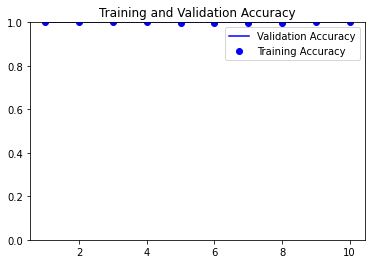

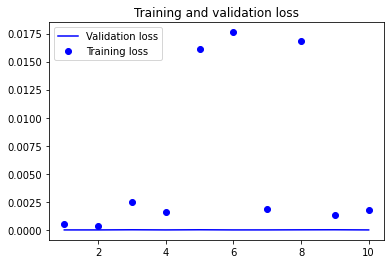

Bin  13 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 137ms/step - loss: 4.3404e-04 - acc: 1.0000 - val_loss: 6.9172e-04 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 128ms/step - loss: 3.3146e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 14s 135ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 129ms/step - loss: 3.0094e-04 - acc: 1.0000 - val_loss: 8.1822e-04 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 127ms/step - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 0.9688
Epoch 6/10
100/100 [==============================] - 14s 135ms/step - loss: 0.0061 - acc: 0.9980 - val_loss: 2.8517e-04 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 1

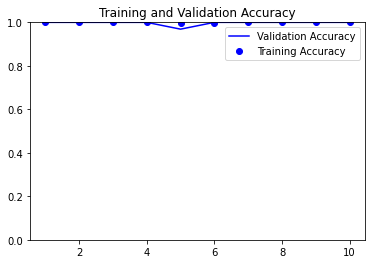

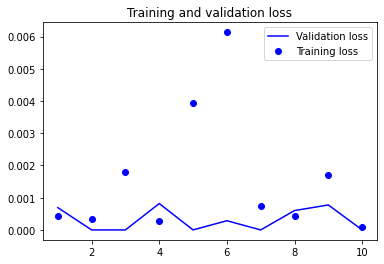

Bin  14 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 136ms/step - loss: 1.6599e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 129ms/step - loss: 2.3796e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0011 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 129ms/step - loss: 2.8343e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 126ms/step - loss: 1.9337e-05 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 132ms/step - loss: 1.5699e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [===========================

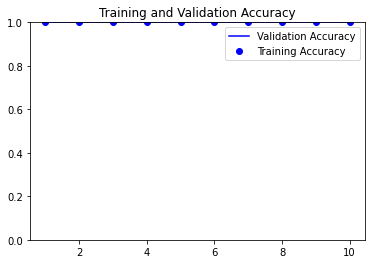

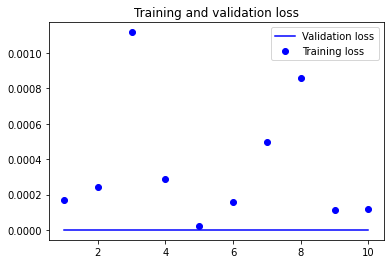

Bin  15 out of 15
Found 451 images belonging to 3 classes.
Found 32 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 14s 139ms/step - loss: 1.8400e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 13s 125ms/step - loss: 0.0058 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 13s 130ms/step - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 13s 128ms/step - loss: 5.9026e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 1.2318e-06 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0271 - acc: 0.9969 - val_loss: 3.1789e-07 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 13s 1

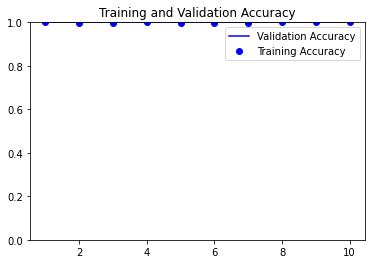

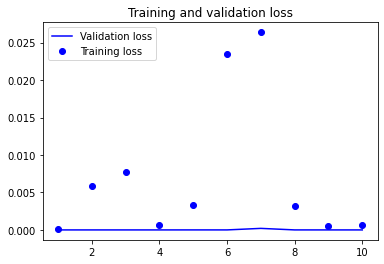

In [0]:
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

run_k_fold_cross_val(model2, 15, steps_per_epoch=100, epochs=10, validation_steps=50)

In [0]:
model2.evaluate_generator(test_gen)

[0.0, 0.9674796462059021]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              

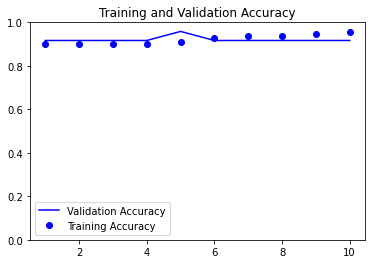

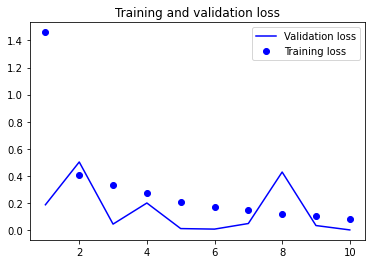

Bin  2 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 121ms/step - loss: 0.1046 - acc: 0.9634 - val_loss: 0.0504 - val_acc: 0.9583
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0811 - acc: 0.9674 - val_loss: 0.0087 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0629 - acc: 0.9729 - val_loss: 6.9737e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0622 - acc: 0.9764 - val_loss: 0.0050 - val_acc: 0.9583
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0406 - acc: 0.9870 - val_loss: 6.6161e-06 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0347 - acc: 0.9875 - val_loss: 3.3080e-06 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0

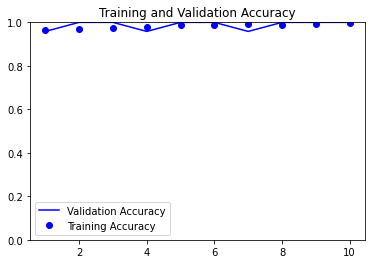

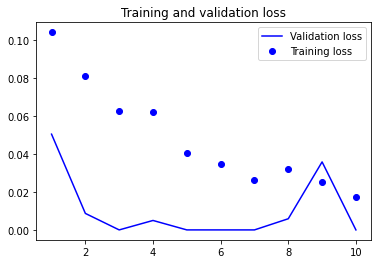

Bin  3 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0149 - acc: 0.9965 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0182 - acc: 0.9950 - val_loss: 3.0994e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0170 - acc: 0.9945 - val_loss: 9.5842e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0113 - acc: 0.9975 - val_loss: 2.3842e-08 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0127 - acc: 0.9970 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0123 - acc: 0.9975 - val_loss: 2.3842e-08 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - loss:

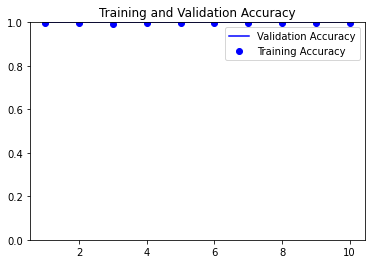

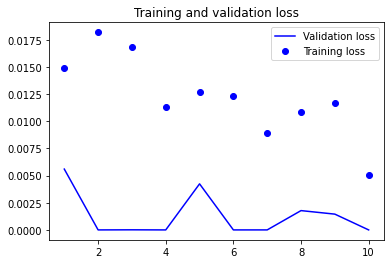

Bin  4 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 118ms/step - loss: 0.0133 - acc: 0.9985 - val_loss: 2.2650e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0103 - acc: 0.9980 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0073 - acc: 0.9975 - val_loss: 2.0862e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0055 - acc: 0.9995 - val_loss: 8.1169e-04 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0082 - acc: 0.9985 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 118ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 5.8412e-06 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - l

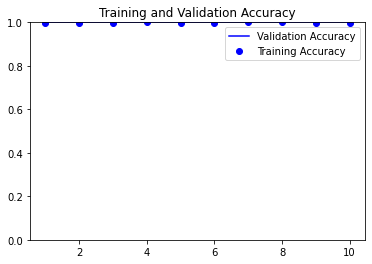

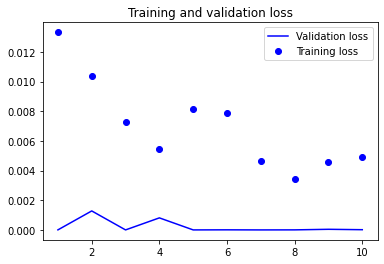

Bin  5 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 121ms/step - loss: 0.0039 - acc: 0.9995 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 107ms/step - loss: 0.0033 - acc: 0.9995 - val_loss: 7.9530e-05 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 118ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0033 - acc: 0.9995 - val_loss: 2.3842e-06 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0151 - acc: 0.9955 - val_loss: 2.0862e-06 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 12s 117ms/step

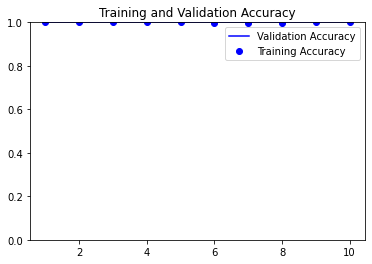

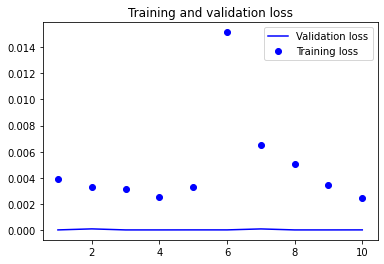

Bin  6 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 120ms/step - loss: 0.0045 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 0.0032 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 8.9407e-08 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0029 - acc: 0.9990 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 118ms/step - loss: 0.0027 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 114ms/step

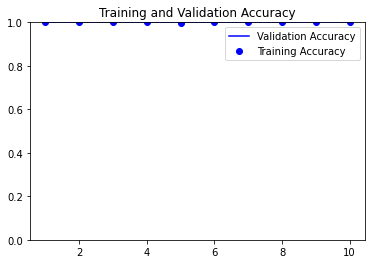

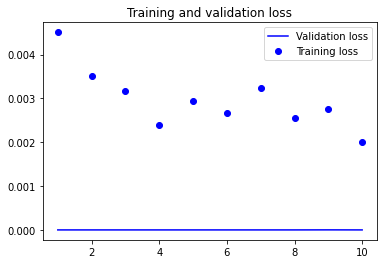

Bin  7 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 2.2696e-05 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 9.6918e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 1.6164e-05 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 6.5803e-06 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 113ms/

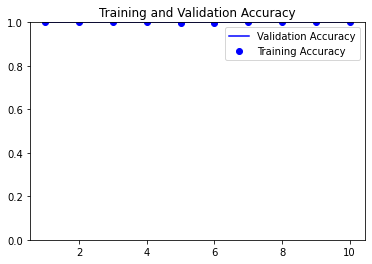

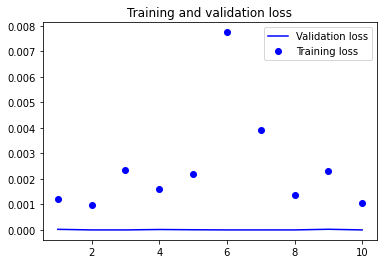

Bin  8 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0018 - acc: 0.9995 - val_loss: 1.8477e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0011 - acc: 0.9995 - val_loss: 2.4467e-05 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 115ms/step - loss: 0.0020 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 1.9728e-05 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 3.7489e-05 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 113ms/step

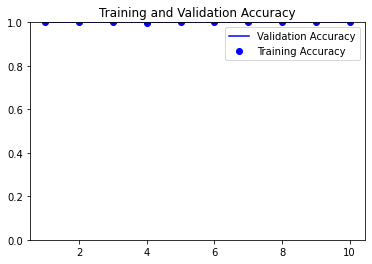

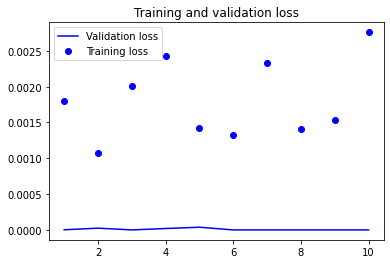

Bin  9 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0031 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 0.0043 - acc: 0.9985 - val_loss: 4.8875e-06 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 0.0028 - acc: 0.9995 - val_loss: 2.5748e-05 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 114ms/step

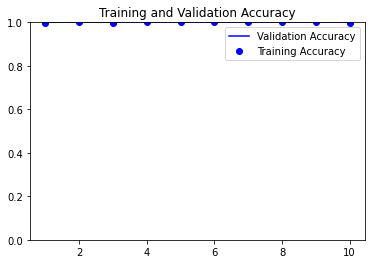

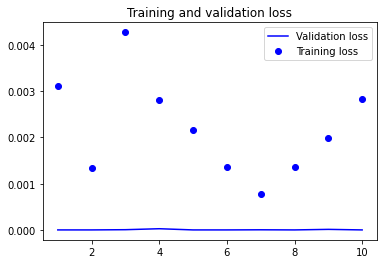

Bin  10 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 3.8743e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 6.8903e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 3.2783e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 124ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 114ms

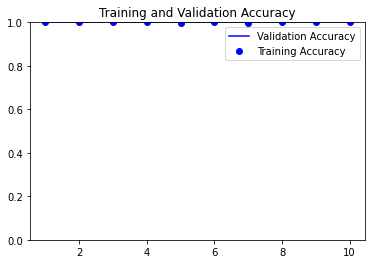

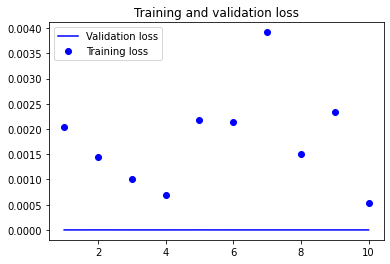

Bin  11 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 3.0398e-06 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 114ms/step - loss: 5.6651e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0019 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 9.8750e-04 - acc: 1.0000 - val_loss: 5.6326e-06 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 11s 115ms/step - loss: 7.2846e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 1

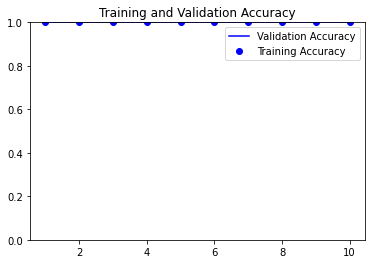

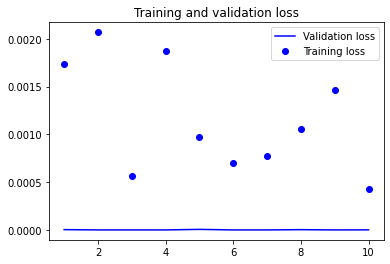

Bin  12 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 119ms/step - loss: 0.0020 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 4.4703e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 1.5199e-06 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 9.0964e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 111ms

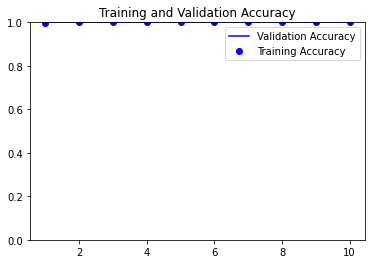

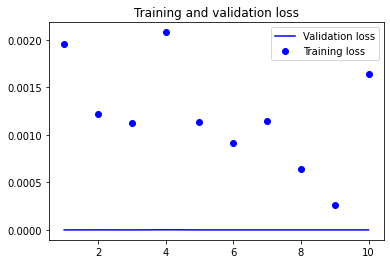

Bin  13 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 8.7821e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 5.6903e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 9.1880e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 8.0900e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 120ms/step - loss: 9.2410e-04 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [===========================

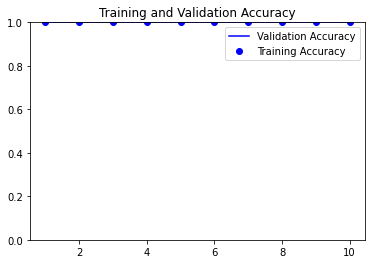

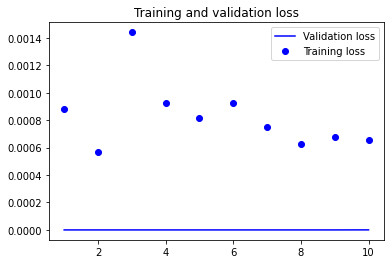

Bin  14 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 120ms/step - loss: 6.3111e-04 - acc: 1.0000 - val_loss: 4.1723e-07 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 7.6803e-04 - acc: 1.0000 - val_loss: 3.8743e-07 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 110ms/step - loss: 5.6639e-04 - acc: 1.0000 - val_loss: 2.9802e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 9.4082e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 11s 113ms/step - loss: 2.7845e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [===========================

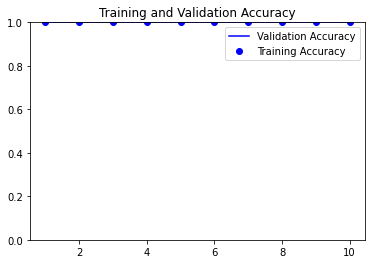

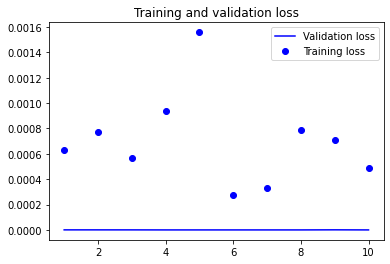

Bin  15 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0033 - acc: 0.9990 - val_loss: 9.2684e-06 - val_acc: 0.9583
Epoch 3/10
100/100 [==============================] - 12s 118ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 114ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 2.3842e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 11s 108ms/ste

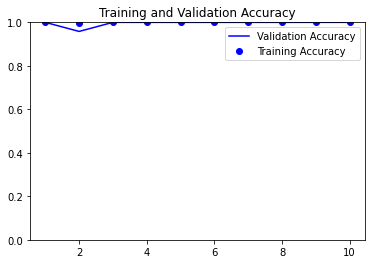

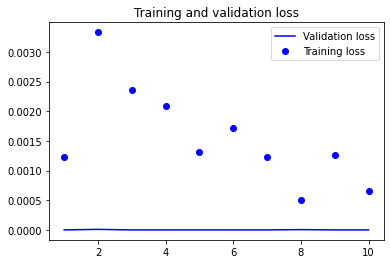

Bin  16 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 120ms/step - loss: 4.4695e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 7.2485e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 112ms/step - loss: 4.7883e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 108ms/step - loss: 5.3940e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 3.7016e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [===========================

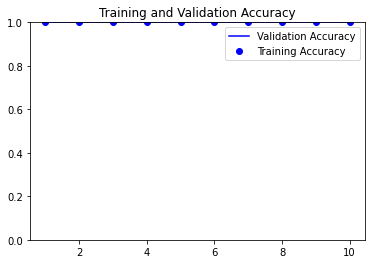

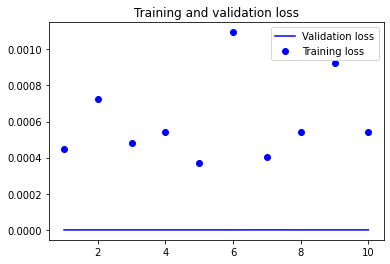

Bin  17 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 120ms/step - loss: 0.0010 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 106ms/step - loss: 8.6006e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 114ms/step - loss: 7.6338e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 3.7672e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 108ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 1

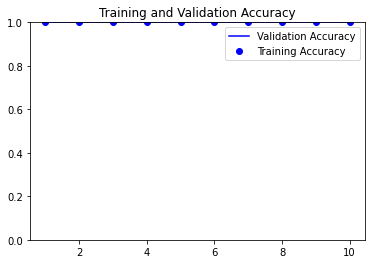

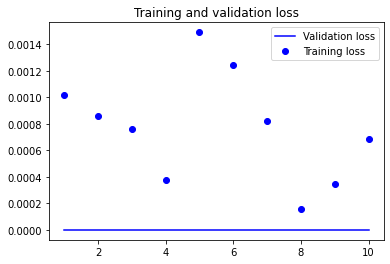

Bin  18 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 117ms/step - loss: 7.1147e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 8.5876e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 8.0863e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 9.2142e-04 - acc: 0.9995 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 1.6991e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 6.9210e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [=======================

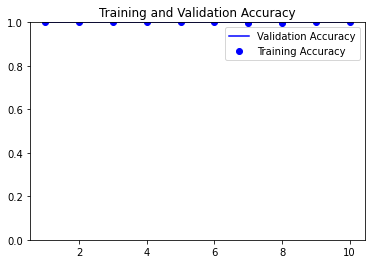

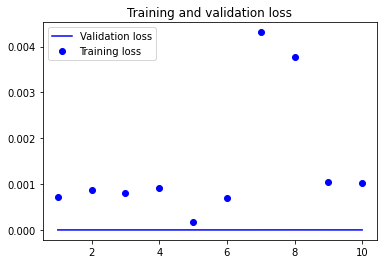

Bin  19 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 117ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 8.3221e-04 - acc: 1.0000 - val_loss: 1.1027e-06 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 11s 111ms/step - loss: 8.9501e-04 - acc: 1.0000 - val_loss: 6.8545e-07 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 110ms/step - loss: 8.5375e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 4.3115e-04 - acc: 1.0000 - val_loss: 4.7684e-07 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 12s 116ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================]

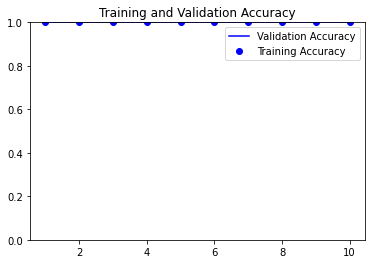

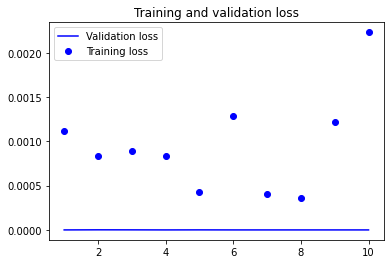

Bin  20 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 6.5942e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 6.5919e-04 - acc: 1.0000 - val_loss: 5.9605e-08 - val_acc: 1.0000
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 2.9247e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 2.6283e-04 - acc: 1.0000 - val_loss: 2.9802e-08 - val_acc: 1.0000
Epoch 5/10
100/100 [==============================] - 11s 109ms/step - loss: 5.5083e-04 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 11s 113ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/10
100/100 [===========================

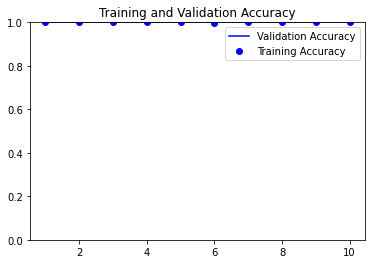

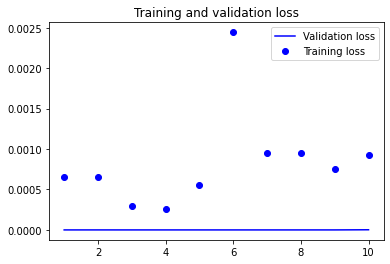

[0.0, 0.9756097793579102]

In [0]:
model3 = models.Sequential()
model3.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3)))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.summary()

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adagrad(),
              metrics=['acc'])

run_k_fold_cross_val(model3, 20, steps_per_epoch=100, epochs=10, validation_steps=50)
model3.evaluate_generator(test_gen)

In [0]:
model3.evaluate_generator(test_gen)

[0.0, 0.9756097793579102]

In [0]:
return_data(img_dir, trn_dir, val_dir)

In [0]:
split_data(img_dir, trn_dir, val_dir, 0.1)

In [0]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=50, class_mode='categorical')

Found 547 images belonging to 3 classes.


In [0]:
model3.evaluate_generator(test_gen)

[0.005496190395206213, 0.9963436722755432]

In [0]:
model2.evaluate_generator(test_gen)

[0.04113013669848442, 0.9945155382156372]

In [0]:
model.evaluate_generator(test_gen)

[1.6190626411116682e-05, 0.9908592104911804]

In [0]:
from keras.regularizers import l2

return_data(img_dir, trn_dir, val_dir)
split_data(img_dir, trn_dir, val_dir, 0.8)

model4 = models.Sequential()
model4.add(layers.Conv2D(256, (3, 3), activation='relu', 
                         padding='same', 
                         input_shape=(64, 64, 3),
                         kernel_regularizer=l2(0.1),
                         bias_regularizer=l2(0.1)))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu',
                         padding='same',
                         kernel_regularizer=l2(0.1),
                         bias_regularizer=l2(0.1)))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='relu',
                        kernel_regularizer=l2(0.1),
                        bias_regularizer=l2(0.1)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(64, activation='relu',
                        kernel_regularizer=l2(0.1),
                        bias_regularizer=l2(0.1)))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(32, activation='relu',
                        kernel_regularizer=l2(0.1),
                        bias_regularizer=l2(0.1)))
model4.add(layers.Dense(3, activation='softmax'))

model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

Bin  1 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 125ms/step - loss: 5.9744 - acc: 0.8962 - val_loss: 1.9670 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 1.8658 - acc: 0.8998 - val_loss: 1.8822 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 1.3503 - acc: 0.9038 - val_loss: 0.9234 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 12s 115ms/step - loss: 1.1171 - acc: 0.9028 - val_loss: 0.7505 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 12s 119ms/step - loss: 0.9756 - acc: 0.9013 - val_loss: 0.5946 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 118ms/step - loss: 0.8709 - acc: 0.9023 - val_loss: 0.5312 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.8107 - acc: 0

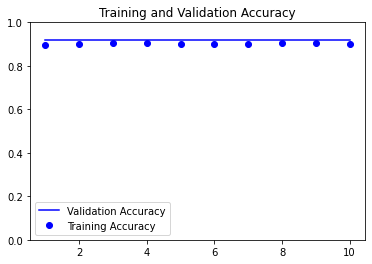

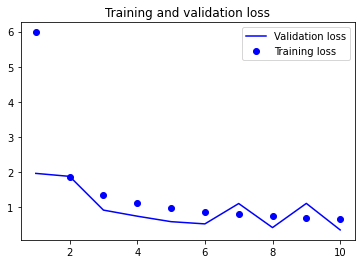

Bin  2 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.6338 - acc: 0.9043 - val_loss: 1.0770 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 0.6381 - acc: 0.8997 - val_loss: 0.3141 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 118ms/step - loss: 0.6107 - acc: 0.9018 - val_loss: 0.3090 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.5940 - acc: 0.9008 - val_loss: 0.9348 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 114ms/step - loss: 0.5738 - acc: 0.9038 - val_loss: 0.9999 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 120ms/step - loss: 0.5685 - acc: 0.9023 - val_loss: 0.9911 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.5636 - acc: 0

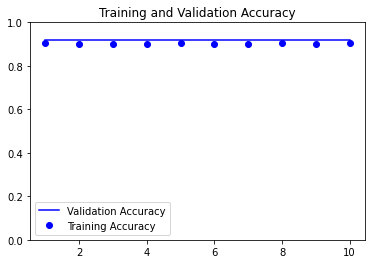

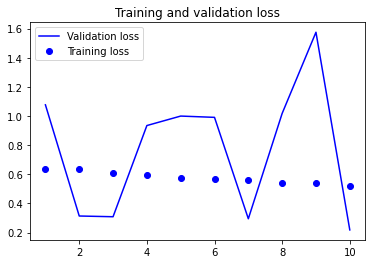

Bin  3 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 134ms/step - loss: 0.5167 - acc: 0.9055 - val_loss: 0.8182 - val_acc: 0.8400
Epoch 2/10
100/100 [==============================] - 13s 127ms/step - loss: 0.5068 - acc: 0.9071 - val_loss: 1.2561 - val_acc: 0.8400
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 0.5040 - acc: 0.9061 - val_loss: 0.7865 - val_acc: 0.8400
Epoch 4/10
100/100 [==============================] - 12s 124ms/step - loss: 0.5036 - acc: 0.9045 - val_loss: 0.2347 - val_acc: 0.8400
Epoch 5/10
100/100 [==============================] - 13s 127ms/step - loss: 0.5013 - acc: 0.9056 - val_loss: 1.2470 - val_acc: 0.8400
Epoch 6/10
100/100 [==============================] - 13s 128ms/step - loss: 0.4831 - acc: 0.9081 - val_loss: 0.2109 - val_acc: 0.8400
Epoch 7/10
100/100 [==============================] - 12s 122ms/step - loss: 0.4879 - acc: 0

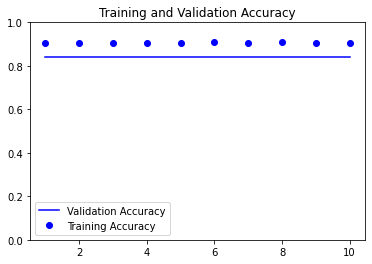

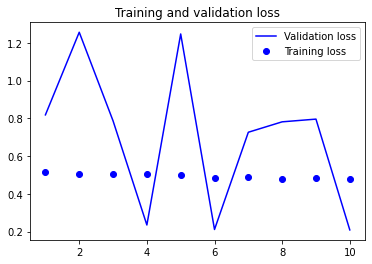

Bin  4 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 129ms/step - loss: 0.4891 - acc: 0.9008 - val_loss: 0.2292 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 12s 118ms/step - loss: 0.4823 - acc: 0.9033 - val_loss: 0.8401 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 120ms/step - loss: 0.4823 - acc: 0.9028 - val_loss: 0.8495 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 12s 118ms/step - loss: 0.4769 - acc: 0.9029 - val_loss: 0.1984 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4772 - acc: 0.9008 - val_loss: 0.1982 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4770 - acc: 0.9008 - val_loss: 0.9252 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4700 - acc: 0

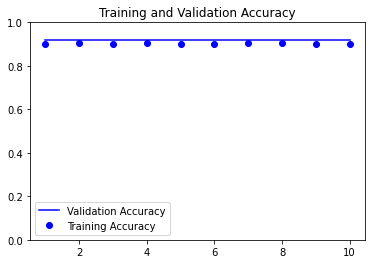

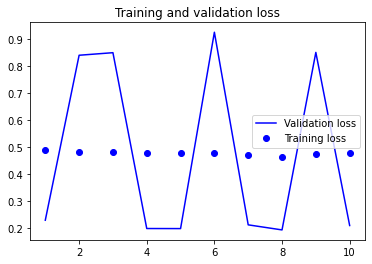

Bin  5 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 126ms/step - loss: 0.4647 - acc: 0.9028 - val_loss: 0.8667 - val_acc: 0.8750
Epoch 2/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4538 - acc: 0.9059 - val_loss: 0.1949 - val_acc: 0.8750
Epoch 3/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4608 - acc: 0.9048 - val_loss: 0.1980 - val_acc: 0.8750
Epoch 4/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4693 - acc: 0.9003 - val_loss: 0.2093 - val_acc: 0.8750
Epoch 5/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4435 - acc: 0.9093 - val_loss: 0.1758 - val_acc: 0.8750
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4634 - acc: 0.9013 - val_loss: 0.8416 - val_acc: 0.8750
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4591 - acc: 0

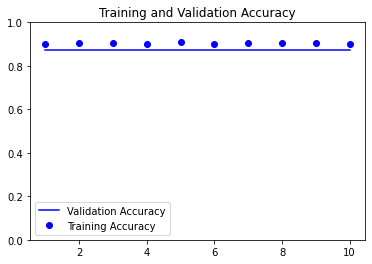

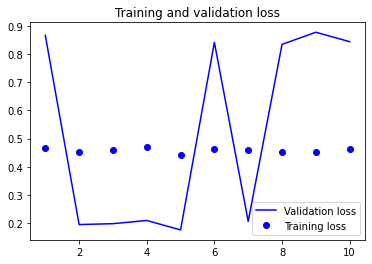

Bin  6 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 133ms/step - loss: 0.4542 - acc: 0.9031 - val_loss: 1.2483 - val_acc: 0.8800
Epoch 2/10
100/100 [==============================] - 12s 122ms/step - loss: 0.4540 - acc: 0.9020 - val_loss: 0.1937 - val_acc: 0.8800
Epoch 3/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4449 - acc: 0.9066 - val_loss: 0.1956 - val_acc: 0.8800
Epoch 4/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4479 - acc: 0.9036 - val_loss: 0.7381 - val_acc: 0.8800
Epoch 5/10
100/100 [==============================] - 12s 122ms/step - loss: 0.4469 - acc: 0.9041 - val_loss: 0.1905 - val_acc: 0.8800
Epoch 6/10
100/100 [==============================] - 13s 127ms/step - loss: 0.4493 - acc: 0.9030 - val_loss: 0.7205 - val_acc: 0.8800
Epoch 7/10
100/100 [==============================] - 12s 121ms/step - loss: 0.4405 - acc: 0

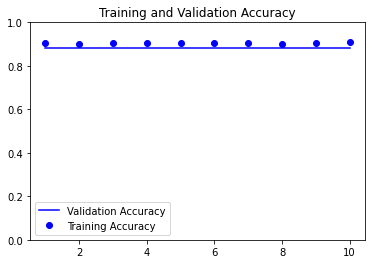

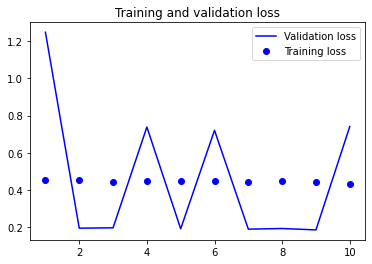

Bin  7 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4399 - acc: 0.9053 - val_loss: 0.8245 - val_acc: 0.8750
Epoch 2/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4384 - acc: 0.9048 - val_loss: 0.8278 - val_acc: 0.8750
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4431 - acc: 0.9028 - val_loss: 0.8728 - val_acc: 0.8750
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4388 - acc: 0.9043 - val_loss: 0.8404 - val_acc: 0.8750
Epoch 5/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4387 - acc: 0.9043 - val_loss: 0.1874 - val_acc: 0.8750
Epoch 6/10
100/100 [==============================] - 12s 121ms/step - loss: 0.4392 - acc: 0.9033 - val_loss: 0.8285 - val_acc: 0.8750
Epoch 7/10
100/100 [==============================] - 12s 115ms/step - loss: 0.4336 - acc: 0

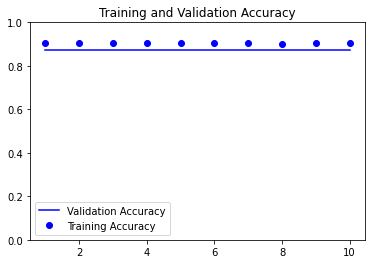

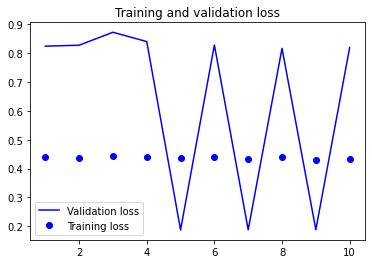

Bin  8 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4453 - acc: 0.8988 - val_loss: 0.8337 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 0.4265 - acc: 0.9053 - val_loss: 0.1845 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 0.4339 - acc: 0.9018 - val_loss: 0.8054 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 12s 118ms/step - loss: 0.4355 - acc: 0.9003 - val_loss: 0.1818 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4281 - acc: 0.9023 - val_loss: 0.1785 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4206 - acc: 0.9043 - val_loss: 0.8030 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4297 - acc: 0

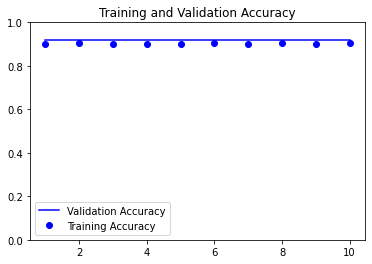

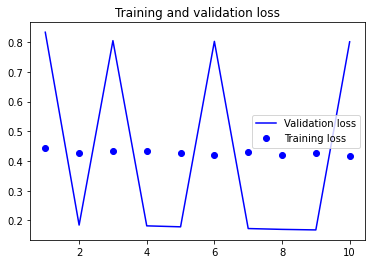

Bin  9 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 126ms/step - loss: 0.4199 - acc: 0.9018 - val_loss: 0.1641 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4234 - acc: 0.9003 - val_loss: 0.1630 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 119ms/step - loss: 0.4106 - acc: 0.9048 - val_loss: 0.1609 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4188 - acc: 0.9013 - val_loss: 0.8313 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4099 - acc: 0.9044 - val_loss: 0.1579 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 121ms/step - loss: 0.4213 - acc: 0.8997 - val_loss: 0.1575 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4260 - acc: 0

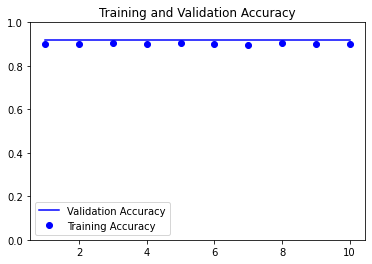

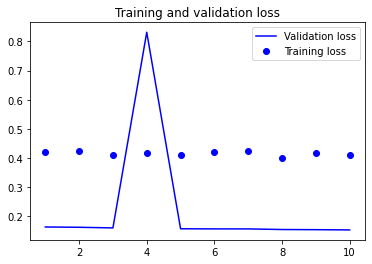

Bin  10 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4189 - acc: 0.8997 - val_loss: 0.7994 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4022 - acc: 0.9058 - val_loss: 0.1522 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4166 - acc: 0.9003 - val_loss: 0.8332 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4026 - acc: 0.9053 - val_loss: 0.1506 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.4239 - acc: 0.8973 - val_loss: 0.1511 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 121ms/step - loss: 0.4064 - acc: 0.9038 - val_loss: 0.7994 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4203 - acc: 

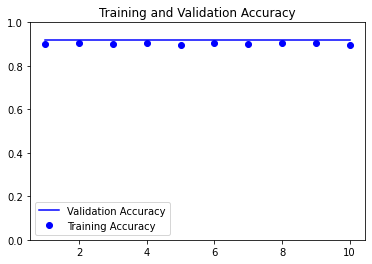

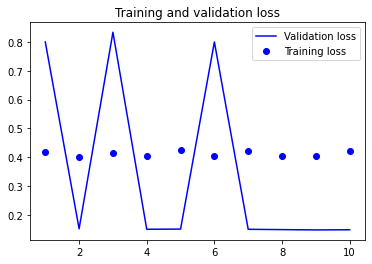

Bin  11 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4049 - acc: 0.9038 - val_loss: 0.7989 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 108ms/step - loss: 0.4153 - acc: 0.8998 - val_loss: 0.1476 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4055 - acc: 0.9033 - val_loss: 0.1468 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4133 - acc: 0.9003 - val_loss: 0.7990 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4093 - acc: 0.9018 - val_loss: 0.1461 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 120ms/step - loss: 0.4087 - acc: 0.9018 - val_loss: 0.7991 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 113ms/step - loss: 0.3976 - acc: 

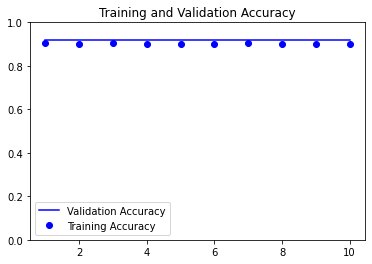

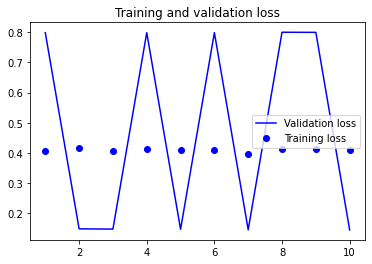

Bin  12 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.3968 - acc: 0.9058 - val_loss: 0.1428 - val_acc: 0.8750
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4096 - acc: 0.9008 - val_loss: 0.8337 - val_acc: 0.8750
Epoch 3/10
100/100 [==============================] - 12s 118ms/step - loss: 0.3975 - acc: 0.9053 - val_loss: 0.8345 - val_acc: 0.8750
Epoch 4/10
100/100 [==============================] - 12s 116ms/step - loss: 0.3920 - acc: 0.9073 - val_loss: 0.1407 - val_acc: 0.8750
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4082 - acc: 0.9013 - val_loss: 0.1410 - val_acc: 0.8750
Epoch 6/10
100/100 [==============================] - 12s 116ms/step - loss: 0.3997 - acc: 0.9043 - val_loss: 0.1405 - val_acc: 0.8750
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3983 - acc: 

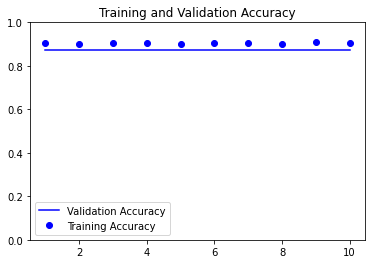

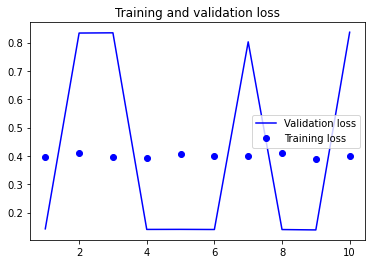

Bin  13 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 123ms/step - loss: 0.4012 - acc: 0.9033 - val_loss: 0.8365 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 115ms/step - loss: 0.4080 - acc: 0.9008 - val_loss: 0.1389 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4066 - acc: 0.9013 - val_loss: 0.8004 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.3978 - acc: 0.9043 - val_loss: 0.1385 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4119 - acc: 0.8992 - val_loss: 0.8351 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 0.4031 - acc: 0.9023 - val_loss: 0.1387 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 118ms/step - loss: 0.4074 - acc: 

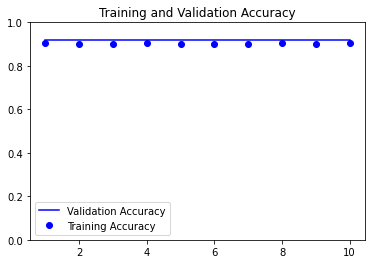

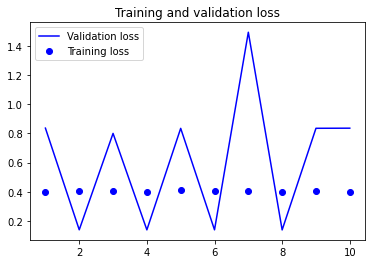

Bin  14 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.4116 - acc: 0.8988 - val_loss: 0.1379 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3881 - acc: 0.9078 - val_loss: 0.8001 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 120ms/step - loss: 0.4113 - acc: 0.8988 - val_loss: 0.1371 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4113 - acc: 0.8988 - val_loss: 0.1376 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.3970 - acc: 0.9043 - val_loss: 0.7980 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 115ms/step - loss: 0.3993 - acc: 0.9033 - val_loss: 0.1365 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 115ms/step - loss: 0.4055 - acc: 

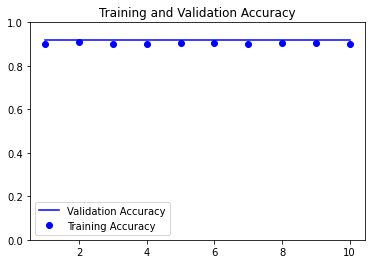

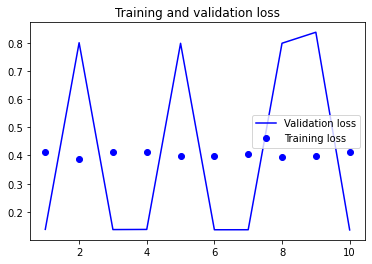

Bin  15 out of 20
Found 458 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 13s 134ms/step - loss: 0.3978 - acc: 0.9036 - val_loss: 0.1354 - val_acc: 0.8800
Epoch 2/10
100/100 [==============================] - 12s 115ms/step - loss: 0.3982 - acc: 0.9035 - val_loss: 0.6655 - val_acc: 0.8800
Epoch 3/10
100/100 [==============================] - 12s 119ms/step - loss: 0.3925 - acc: 0.9051 - val_loss: 1.2608 - val_acc: 0.8800
Epoch 4/10
100/100 [==============================] - 11s 115ms/step - loss: 0.3989 - acc: 0.9031 - val_loss: 0.6657 - val_acc: 0.8800
Epoch 5/10
100/100 [==============================] - 11s 115ms/step - loss: 0.3968 - acc: 0.9036 - val_loss: 0.6979 - val_acc: 0.8800
Epoch 6/10
100/100 [==============================] - 13s 128ms/step - loss: 0.3958 - acc: 0.9040 - val_loss: 0.1335 - val_acc: 0.8800
Epoch 7/10
100/100 [==============================] - 12s 117ms/step - loss: 0.3971 - acc: 

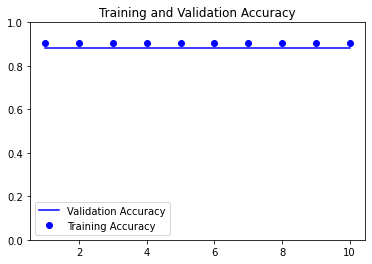

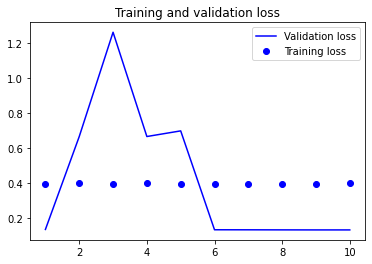

Bin  16 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.3960 - acc: 0.9038 - val_loss: 0.1323 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 110ms/step - loss: 0.4081 - acc: 0.8992 - val_loss: 0.1329 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 115ms/step - loss: 0.3983 - acc: 0.9028 - val_loss: 0.1327 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4030 - acc: 0.9013 - val_loss: 0.1327 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 111ms/step - loss: 0.3928 - acc: 0.9048 - val_loss: 0.1321 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.4049 - acc: 0.9003 - val_loss: 0.7971 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4051 - acc: 

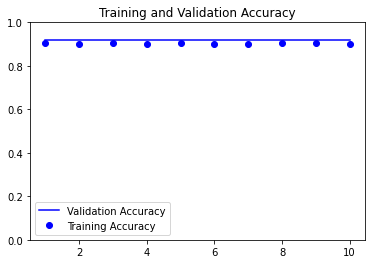

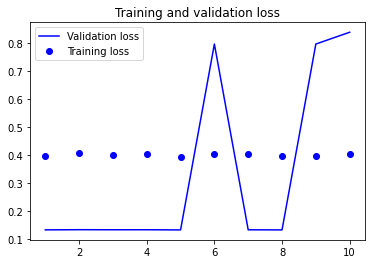

Bin  17 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 122ms/step - loss: 0.4034 - acc: 0.9008 - val_loss: 0.8392 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4010 - acc: 0.9018 - val_loss: 0.1319 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 11s 115ms/step - loss: 0.3956 - acc: 0.9033 - val_loss: 0.1315 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 0.4003 - acc: 0.9018 - val_loss: 0.1314 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 108ms/step - loss: 0.4030 - acc: 0.9008 - val_loss: 0.1315 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3944 - acc: 0.9038 - val_loss: 0.1311 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3978 - acc: 

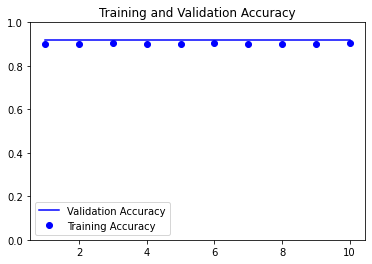

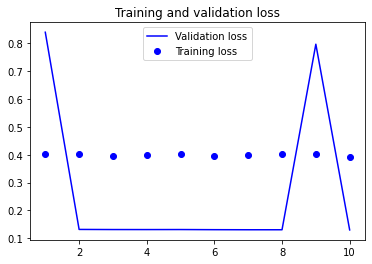

Bin  18 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.3984 - acc: 0.9023 - val_loss: 0.1301 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 111ms/step - loss: 0.3942 - acc: 0.9038 - val_loss: 0.1297 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4036 - acc: 0.9003 - val_loss: 0.1299 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 12s 115ms/step - loss: 0.3996 - acc: 0.9018 - val_loss: 0.7968 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.3984 - acc: 0.9023 - val_loss: 0.1297 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 121ms/step - loss: 0.3968 - acc: 0.9028 - val_loss: 0.1295 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 111ms/step - loss: 0.4048 - acc: 

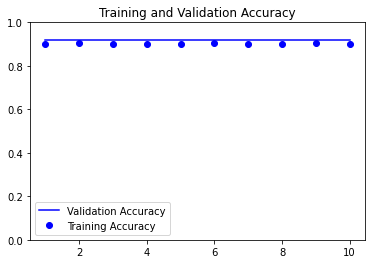

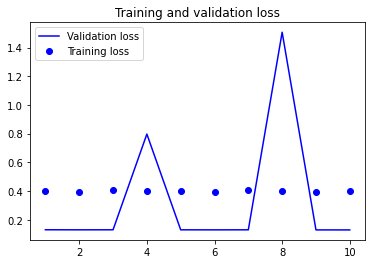

Bin  19 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 124ms/step - loss: 0.4028 - acc: 0.9003 - val_loss: 0.8405 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3913 - acc: 0.9048 - val_loss: 0.8411 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 118ms/step - loss: 0.4013 - acc: 0.9008 - val_loss: 0.1288 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4034 - acc: 0.9003 - val_loss: 0.1290 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 112ms/step - loss: 0.3945 - acc: 0.9034 - val_loss: 0.1287 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 117ms/step - loss: 0.3960 - acc: 0.9028 - val_loss: 0.7965 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 12s 116ms/step - loss: 0.3957 - acc: 

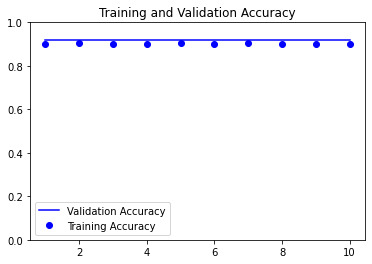

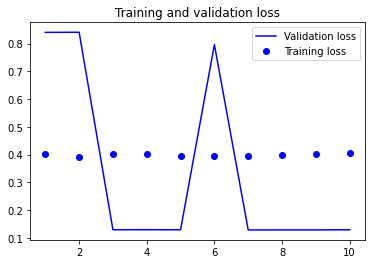

Bin  20 out of 20
Found 459 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
Epoch 1/10
100/100 [==============================] - 12s 121ms/step - loss: 0.3977 - acc: 0.9023 - val_loss: 0.1284 - val_acc: 0.9167
Epoch 2/10
100/100 [==============================] - 11s 109ms/step - loss: 0.3973 - acc: 0.9023 - val_loss: 0.7961 - val_acc: 0.9167
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.3978 - acc: 0.9023 - val_loss: 0.1279 - val_acc: 0.9167
Epoch 4/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4000 - acc: 0.9013 - val_loss: 0.1279 - val_acc: 0.9167
Epoch 5/10
100/100 [==============================] - 11s 110ms/step - loss: 0.3975 - acc: 0.9023 - val_loss: 0.1276 - val_acc: 0.9167
Epoch 6/10
100/100 [==============================] - 12s 116ms/step - loss: 0.4030 - acc: 0.9003 - val_loss: 1.4657 - val_acc: 0.9167
Epoch 7/10
100/100 [==============================] - 11s 114ms/step - loss: 0.3973 - acc: 

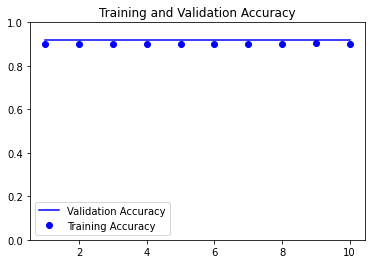

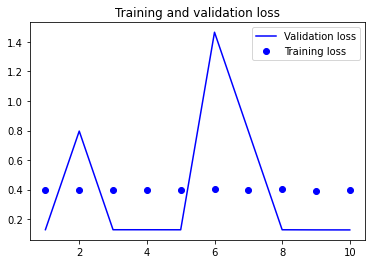

In [0]:
model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adagrad(),
              metrics=['acc'])

run_k_fold_cross_val(model4, k=20, epochs=10)

In [0]:
return_data(img_dir, trn_dir, val_dir)
split_data(img_dir, trn_dir, val_dir, 0.1)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=(64, 64),
                                         batch_size=50, class_mode='categorical')
model4.evaluate_generator(test_gen)

Found 547 images belonging to 3 classes.


[0.5447115302085876, 0.8994515538215637]

In [6]:
load_data()


Unzipping the files..
Moving files to data/img


(480, 640, 3)


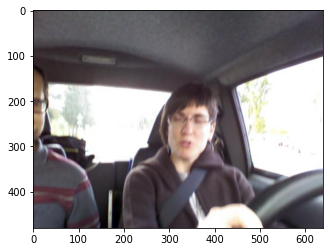

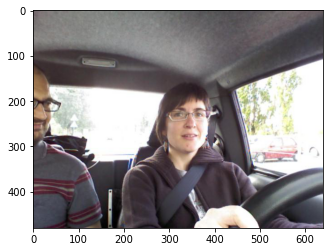

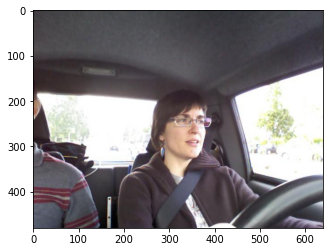

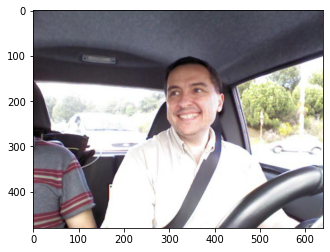

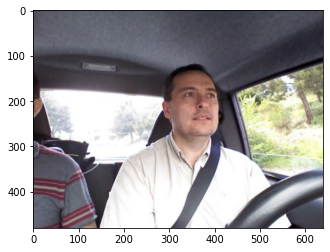

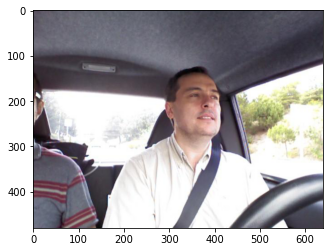

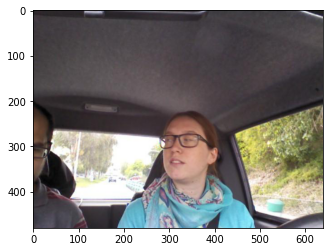

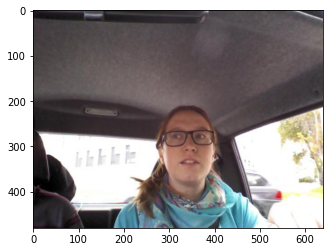

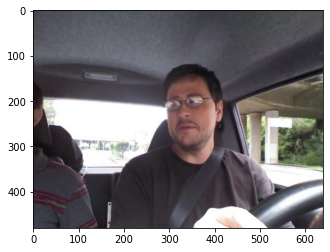

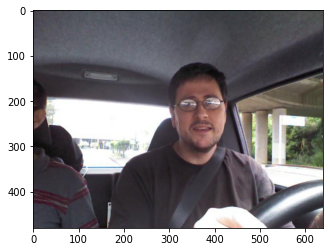

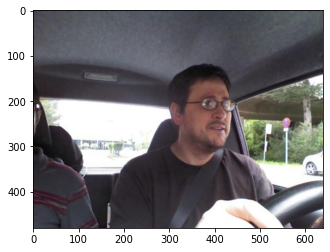

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.image as mpimg

name = df[(df['subject']==1) & (df['label']==1)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
print(mpimg.imread(path).shape)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==1) & (df['label']==2)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==1) & (df['label']==3)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==2) & (df['label']==1)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==2) & (df['label']==2)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==2) & (df['label']==3)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==3) & (df['label']==1)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==3) & (df['label']==2)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==4) & (df['label']==1)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==4) & (df['label']==2)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()
name = df[(df['subject']==4) & (df['label']==3)].iloc[0]['fileName'] + '.jpg'
path = os.path.join(img_dir, name)
plt.imshow(mpimg.imread(path))
plt.show()
plt.figure()